In [944]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from math import sqrt
import statsmodels.api as sm
from statsmodels.formula.api import ols

**Project Goal:** The goal of this project is to study if we can predict per capita income in a county from the data on fresh markets in the county.

Let's create separate dataframes for data from the two csv file.

In [945]:
df_FM1=pd.read_csv('farmers_markets_from_usda.csv')   #initial dataframe with data on farmer's market.

In [946]:
df_FM1.head(2)

,FMID,MarketName,Website,Facebook,Twitter,Youtube,OtherMedia,street,city,County,...,Coffee,Beans,Fruits,Grains,Juices,Mushrooms,PetFood,Tofu,WildHarvested,updateTime
0,1018261,Caledonia Farmers Market Association - Danville,https://sites.google.com/site/caledoniafarmers...,https://www.facebook.com/Danville.VT.Farmers.M...,NaN,NaN,NaN,NaN,Danville,Caledonia,...,Y,Y,Y,N,N,Y,Y,N,N,6/20/2017 22:43
1,1018318,Stearns Homestead Farmers' Market,http://www.StearnsHomestead.com,StearnsHomesteadFarmersMarket,NaN,NaN,NaN,6975 Ridge Road,Parma,Cuyahoga,...,N,N,Y,N,N,N,N,N,N,6/21/2017 17:15


In [947]:
df_county=pd.read_csv('datasets_706231_1233065_wiki_county_info.csv')      #initial dataframe with county information.

In [948]:
df_county.head(2)

,number,county,State,per capita income,median household income,median family income,population,number of households
0,1,New York County,New York,"$62,498","$69,659","$84,627","1,605,272","736,192"
1,2,Arlington,Virginia,"$62,018","$103,208","$139,244","214,861","94,454"


Since the demographic data is given by county, let's sort and group data by county and merge the two dataframes. This will make data analysis and machine learning easier.

In [949]:
df_county_count=pd.DataFrame(df_FM1['County'].value_counts())

In [950]:
df_county_count.rename(columns={'County':'County_Count'},inplace=True)

In [951]:
df_county_count.head()

,County_Count
Los Angeles,128
Cook,111
Jefferson,100
Washington,93
Franklin,87


In [952]:
df_FM1.columns.values

array(['FMID', 'MarketName', 'Website', 'Facebook', 'Twitter', 'Youtube',
       'OtherMedia', 'street', 'city', 'County', 'State', 'zip',
       'Season1Date', 'Season1Time', 'Season2Date', 'Season2Time',
       'Season3Date', 'Season3Time', 'Season4Date', 'Season4Time', 'x',
       'y', 'Location', 'Credit', 'WIC', 'WICcash', 'SFMNP', 'SNAP',
       'Organic', 'Bakedgoods', 'Cheese', 'Crafts', 'Flowers', 'Eggs',
       'Seafood', 'Herbs', 'Vegetables', 'Honey', 'Jams', 'Maple', 'Meat',
       'Nursery', 'Nuts', 'Plants', 'Poultry', 'Prepared', 'Soap',
       'Trees', 'Wine', 'Coffee', 'Beans', 'Fruits', 'Grains', 'Juices',
       'Mushrooms', 'PetFood', 'Tofu', 'WildHarvested', 'updateTime'],
      dtype=object)

In [953]:
df_FM1=df_FM1[['FMID', 'Website', 'city', 'County', 'State', 'zip', 'x', 'y', 'Location','Credit', 'WIC', 'WICcash', 'SFMNP', 'SNAP', 'Organic', 'Bakedgoods', 'Cheese', 'Crafts', 'Flowers', 'Eggs', 'Seafood','Herbs', 'Vegetables', 'Honey', 'Jams', 'Maple', 'Meat', 'Nursery','Nuts', 'Plants', 'Poultry', 'Prepared', 'Soap', 'Trees', 'Wine','Coffee', 'Beans', 'Fruits', 'Grains', 'Juices', 'Mushrooms','PetFood', 'Tofu', 'WildHarvested']].copy(deep=True)

In [954]:
df_FM1.head(20)

,FMID,Website,city,County,State,zip,x,y,Location,Credit,...,Wine,Coffee,Beans,Fruits,Grains,Juices,Mushrooms,PetFood,Tofu,WildHarvested
0,1018261,https://sites.google.com/site/caledoniafarmers...,Danville,Caledonia,Vermont,5828,-72.140335,44.411037,NaN,Y,...,N,Y,Y,Y,N,N,Y,Y,N,N
1,1018318,http://www.StearnsHomestead.com,Parma,Cuyahoga,Ohio,NaN,-81.733940,41.374802,NaN,Y,...,N,N,N,Y,N,N,N,N,N,N
2,1009364,http://thetownofsixmile.wordpress.com/,Six Mile,Pickens,South Carolina,29682,-82.818703,34.804199,NaN,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1010691,NaN,Lamar,Barton,Missouri,64759,-94.274620,37.495628,NaN,Y,...,N,N,N,Y,N,N,N,N,N,N
4,1002454,NaN,New York,New York,New York,10029,-73.949303,40.793900,Private business parking lot,N,...,N,N,N,N,N,N,N,N,N,N
5,1011100,http://www.12southfarmersmarket.com,Nashville,Davidson,Tennessee,37204,-86.790710,36.118370,NaN,Y,...,N,Y,N,Y,N,Y,Y,Y,N,N
6,1009845,http://www.125thStreetFarmersMarket.com,New York,New York,New York,10027,-73.948250,40.808952,Federal/State government building grounds,Y,...,Y,Y,N,Y,N,Y,N,N,N,N
7,1005586,NaN,Wilmington,New Castle,Delaware,19801,-75.534462,39.742119,"On a farm from: a barn, a greenhouse, a tent, ...",N,...,N,N,N,Y,N,N,N,N,N,N
8,1008071,NaN,Washington,District of Columbia,District of Columbia,20009,-77.032051,38.917000,Other,Y,...,N,N,Y,Y,Y,Y,N,N,N,N
9,1012710,NaN,Washington,District of Columbia,District of Columbia,20011,-77.033447,38.955978,NaN,Y,...,N,Y,N,Y,N,N,N,Y,N,N


In [955]:
df_FM1['website_count']=df_FM1['Website'].notnull().astype(int)
df_FM1['OrganicYN']=df_FM1['Organic'].str.contains('Y').astype(float)
df_FM1['BakedgoodsYN']=df_FM1['Bakedgoods'].str.contains('Y').astype(float)
df_FM1['CheeseYN']=df_FM1['Cheese'].str.contains('Y').astype(float)
df_FM1['CraftsYN']=df_FM1['Crafts'].str.contains('Y').astype(float)
df_FM1['FlowersYN']=df_FM1['Flowers'].str.contains('Y').astype(float)
df_FM1['EggsYN']=df_FM1['Eggs'].str.contains('Y').astype(float)
df_FM1['SeafoodYN']=df_FM1['Seafood'].str.contains('Y').astype(float)
df_FM1['HerbsYN']=df_FM1['Herbs'].str.contains('Y').astype(float)
df_FM1['VegetablesYN']=df_FM1['Vegetables'].str.contains('Y').astype(float)
df_FM1['HoneyYN']=df_FM1['Honey'].str.contains('Y').astype(float)
df_FM1['JamsYN']=df_FM1['Jams'].str.contains('Y').astype(float)
df_FM1['MapleYN']=df_FM1['Maple'].str.contains('Y').astype(float)
df_FM1['MeatYN']=df_FM1['Meat'].str.contains('Y').astype(float)
df_FM1['NurseryYN']=df_FM1['Nursery'].str.contains('Y').astype(float)
df_FM1['NutsYN']=df_FM1['Nuts'].str.contains('Y').astype(float)
df_FM1['PlantsYN']=df_FM1['Plants'].str.contains('Y').astype(float)
df_FM1['PoultryYN']=df_FM1['Poultry'].str.contains('Y').astype(float)
df_FM1['PreparedYN']=df_FM1['Prepared'].str.contains('Y').astype(float)
df_FM1['SoapYN']=df_FM1['Soap'].str.contains('Y').astype(float)
df_FM1['TreesYN']=df_FM1['Trees'].str.contains('Y').astype(float)
df_FM1['WineYN']=df_FM1['Wine'].str.contains('Y').astype(float)
df_FM1['CoffeeYN']=df_FM1['Coffee'].str.contains('Y').astype(float)
df_FM1['BeansYN']=df_FM1['Beans'].str.contains('Y').astype(float)
df_FM1['FruitsYN']=df_FM1['Fruits'].str.contains('Y').astype(float)
df_FM1['GrainsYN']=df_FM1['Grains'].str.contains('Y').astype(float)
df_FM1['JuicesYN']=df_FM1['Juices'].str.contains('Y').astype(float)
df_FM1['MushroomsYN']=df_FM1['Mushrooms'].str.contains('Y').astype(float)
df_FM1['PetFoodYN']=df_FM1['PetFood'].str.contains('Y').astype(float)
df_FM1['TofuYN']=df_FM1['Tofu'].str.contains('Y').astype(float)
df_FM1['WildHarvestedYN']=df_FM1['WildHarvested'].str.contains('Y').astype(float)

In [956]:
df_FM1.head(3)

,FMID,Website,city,County,State,zip,x,y,Location,Credit,...,WineYN,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN
0,1018261,https://sites.google.com/site/caledoniafarmers...,Danville,Caledonia,Vermont,5828,-72.140335,44.411037,NaN,Y,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1018318,http://www.StearnsHomestead.com,Parma,Cuyahoga,Ohio,NaN,-81.733940,41.374802,NaN,Y,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1009364,http://thetownofsixmile.wordpress.com/,Six Mile,Pickens,South Carolina,29682,-82.818703,34.804199,NaN,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [957]:
df_FM1['website_count'].head()

0    1
1    1
2    1
3    0
4    0
Name: website_count, dtype: int64

In [958]:
df_FM1['County_State']=df_FM1['County']+', '+df_FM1['State']

In [959]:
df_FM1.head(3)

,FMID,Website,city,County,State,zip,x,y,Location,Credit,...,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN,County_State
0,1018261,https://sites.google.com/site/caledoniafarmers...,Danville,Caledonia,Vermont,5828,-72.140335,44.411037,NaN,Y,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,"Caledonia, Vermont"
1,1018318,http://www.StearnsHomestead.com,Parma,Cuyahoga,Ohio,NaN,-81.733940,41.374802,NaN,Y,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"Cuyahoga, Ohio"
2,1009364,http://thetownofsixmile.wordpress.com/,Six Mile,Pickens,South Carolina,29682,-82.818703,34.804199,NaN,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Pickens, South Carolina"


At this point we can remove fields such as Website, Facebook etc. without losing too much information.

In [960]:
df_FM2=df_FM1.drop(['FMID','x','y','Website','city','County','State', 'zip', 'Location','Organic', 'Bakedgoods', 'Cheese', 'Crafts', 'Flowers', 'Eggs', 'Seafood','Herbs', 'Vegetables', 'Honey', 'Jams', 'Maple', 'Meat', 'Nursery','Nuts', 'Plants', 'Poultry', 'Prepared', 'Soap', 'Trees', 'Wine','Coffee', 'Beans', 'Fruits', 'Grains', 'Juices', 'Mushrooms','PetFood', 'Tofu', 'WildHarvested'], axis=1).copy(deep=True)

In [961]:
df_FM2.head(2)

,Credit,WIC,WICcash,SFMNP,SNAP,website_count,OrganicYN,BakedgoodsYN,CheeseYN,CraftsYN,...,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN,County_State
0,Y,Y,N,Y,N,1,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,"Caledonia, Vermont"
1,Y,N,N,Y,N,1,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"Cuyahoga, Ohio"


In [962]:
df_County_Counts=pd.DataFrame(df_FM2['County_State'].value_counts())

In [963]:
df_County_Counts.head()

,County_State
"Los Angeles, California",128
"Cook, Illinois",110
"New York, New York",63
"District of Columbia, District of Columbia",60
"Middlesex, Massachusetts",60


In [964]:
df_County_Counts.rename(columns={'County_State':'Counts'},inplace=True)

In [965]:
df_County_Counts.reset_index(inplace=True)
df_County_Counts.head()

,index,Counts
0,"Los Angeles, California",128
1,"Cook, Illinois",110
2,"New York, New York",63
3,"District of Columbia, District of Columbia",60
4,"Middlesex, Massachusetts",60


In [966]:
df_County_Counts.rename(columns={'index':'County_State'},inplace=True)

In [967]:
df_County_Counts.head(3)

,County_State,Counts
0,"Los Angeles, California",128
1,"Cook, Illinois",110
2,"New York, New York",63


In [968]:
df_County_Counts.dtypes

County_State    object
Counts           int64
dtype: object

In [969]:
df_Farmers_Markets=df_FM2.groupby(['County_State']).sum()

In [970]:
df_Farmers_Markets.head()

,website_count,OrganicYN,BakedgoodsYN,CheeseYN,CraftsYN,FlowersYN,EggsYN,SeafoodYN,HerbsYN,VegetablesYN,...,WineYN,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN
County_State,,,,,,,,,,,,,,,,,,,,,
"Abbeville, South Carolina",1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
"Accomack, Virginia",2,2.0,3.0,2.0,2.0,1.0,3.0,3.0,2.0,3.0,...,0.0,0.0,0.0,3.0,0.0,0.0,1.0,2.0,0.0,2.0
"Ada, Idaho",6,5.0,7.0,4.0,6.0,4.0,5.0,3.0,6.0,7.0,...,3.0,3.0,2.0,4.0,3.0,2.0,2.0,1.0,0.0,2.0
"Adair County, Kentucky",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Adair, Iowa",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [971]:
df_Farmers_Markets.reset_index(inplace=True)

In [972]:
df_Farmers_Markets.dtypes

County_State        object
website_count        int64
OrganicYN          float64
BakedgoodsYN       float64
CheeseYN           float64
CraftsYN           float64
FlowersYN          float64
EggsYN             float64
SeafoodYN          float64
HerbsYN            float64
VegetablesYN       float64
HoneyYN            float64
JamsYN             float64
MapleYN            float64
MeatYN             float64
NurseryYN          float64
NutsYN             float64
PlantsYN           float64
PoultryYN          float64
PreparedYN         float64
SoapYN             float64
TreesYN            float64
WineYN             float64
CoffeeYN           float64
BeansYN            float64
FruitsYN           float64
GrainsYN           float64
JuicesYN           float64
MushroomsYN        float64
PetFoodYN          float64
TofuYN             float64
WildHarvestedYN    float64
dtype: object

In [973]:
df_Farmers_Markets.head()

,County_State,website_count,OrganicYN,BakedgoodsYN,CheeseYN,CraftsYN,FlowersYN,EggsYN,SeafoodYN,HerbsYN,...,WineYN,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN
0,"Abbeville, South Carolina",1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Accomack, Virginia",2,2.0,3.0,2.0,2.0,1.0,3.0,3.0,2.0,...,0.0,0.0,0.0,3.0,0.0,0.0,1.0,2.0,0.0,2.0
2,"Ada, Idaho",6,5.0,7.0,4.0,6.0,4.0,5.0,3.0,6.0,...,3.0,3.0,2.0,4.0,3.0,2.0,2.0,1.0,0.0,2.0
3,"Adair County, Kentucky",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Adair, Iowa",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Before moving onto the machine learning phase we need to merge **df_County_Counts** with **df_Farmers_Markets** and add a column with median household income for each county.

In [974]:
df_County_Summary=pd.merge(df_County_Counts,df_Farmers_Markets,on='County_State',how='right')

In [975]:
df_County_Summary.head()

,County_State,Counts,website_count,OrganicYN,BakedgoodsYN,CheeseYN,CraftsYN,FlowersYN,EggsYN,SeafoodYN,...,WineYN,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN
0,"Los Angeles, California",128,93,63.0,63.0,33.0,31.0,53.0,59.0,31.0,...,3.0,31.0,14.0,62.0,11.0,43.0,22.0,3.0,8.0,8.0
1,"Cook, Illinois",110,90,24.0,65.0,53.0,31.0,38.0,39.0,22.0,...,5.0,49.0,16.0,64.0,19.0,31.0,35.0,29.0,11.0,7.0
2,"New York, New York",63,47,24.0,41.0,27.0,5.0,13.0,25.0,18.0,...,10.0,4.0,0.0,44.0,1.0,5.0,2.0,0.0,1.0,3.0
3,"District of Columbia, District of Columbia",60,47,30.0,47.0,32.0,10.0,34.0,44.0,24.0,...,3.0,24.0,16.0,48.0,3.0,20.0,25.0,5.0,3.0,3.0
4,"Middlesex, Massachusetts",60,43,24.0,44.0,37.0,29.0,29.0,42.0,33.0,...,24.0,30.0,5.0,45.0,8.0,20.0,9.0,15.0,3.0,5.0


Let's take another look at df_county we created earlier.

In [976]:
df_county.head()

,number,county,State,per capita income,median household income,median family income,population,number of households
0,1,New York County,New York,"$62,498","$69,659","$84,627","1,605,272","736,192"
1,2,Arlington,Virginia,"$62,018","$103,208","$139,244","214,861","94,454"
2,3,Falls Church City,Virginia,"$59,088","$120,000","$152,857","12,731","5,020"
3,4,Marin,California,"$56,791","$90,839","$117,357","254,643","102,912"
4,5,Alexandria City,Virginia,"$54,608","$85,706","$107,511","143,684","65,369"


In [977]:
df_county=df_county.drop(['number'], axis=1).copy(deep=True)

In [978]:
df_county.head()

,county,State,per capita income,median household income,median family income,population,number of households
0,New York County,New York,"$62,498","$69,659","$84,627","1,605,272","736,192"
1,Arlington,Virginia,"$62,018","$103,208","$139,244","214,861","94,454"
2,Falls Church City,Virginia,"$59,088","$120,000","$152,857","12,731","5,020"
3,Marin,California,"$56,791","$90,839","$117,357","254,643","102,912"
4,Alexandria City,Virginia,"$54,608","$85,706","$107,511","143,684","65,369"


In [979]:
#df_county[df_county['county'].str.contains('County',na=False)]
df_county['county']=df_county['county'].str.replace(' County','')

In [980]:
df_county.head()

,county,State,per capita income,median household income,median family income,population,number of households
0,New York,New York,"$62,498","$69,659","$84,627","1,605,272","736,192"
1,Arlington,Virginia,"$62,018","$103,208","$139,244","214,861","94,454"
2,Falls Church City,Virginia,"$59,088","$120,000","$152,857","12,731","5,020"
3,Marin,California,"$56,791","$90,839","$117,357","254,643","102,912"
4,Alexandria City,Virginia,"$54,608","$85,706","$107,511","143,684","65,369"


In [981]:
df_county['County_State']=df_county['county']+ ', ' +df_county['State']

In [982]:
df_county.head()

,county,State,per capita income,median household income,median family income,population,number of households,County_State
0,New York,New York,"$62,498","$69,659","$84,627","1,605,272","736,192","New York, New York"
1,Arlington,Virginia,"$62,018","$103,208","$139,244","214,861","94,454","Arlington, Virginia"
2,Falls Church City,Virginia,"$59,088","$120,000","$152,857","12,731","5,020","Falls Church City, Virginia"
3,Marin,California,"$56,791","$90,839","$117,357","254,643","102,912","Marin, California"
4,Alexandria City,Virginia,"$54,608","$85,706","$107,511","143,684","65,369","Alexandria City, Virginia"


In [983]:
df_combined=pd.merge(df_county,df_County_Summary,on='County_State',how='right')

In [984]:
df_combined.head()

,county,State,per capita income,median household income,median family income,population,number of households,County_State,Counts,website_count,...,WineYN,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN
0,New York,New York,"$62,498","$69,659","$84,627","1,605,272","736,192","New York, New York",63,47,...,10.0,4.0,0.0,44.0,1.0,5.0,2.0,0.0,1.0,3.0
1,Arlington,Virginia,"$62,018","$103,208","$139,244","214,861","94,454","Arlington, Virginia",12,11,...,1.0,4.0,0.0,10.0,0.0,8.0,1.0,2.0,0.0,0.0
2,Marin,California,"$56,791","$90,839","$117,357","254,643","102,912","Marin, California",15,10,...,6.0,8.0,6.0,9.0,8.0,7.0,6.0,4.0,5.0,2.0
3,Pitkin,Colorado,"$51,814","$72,745","$93,981","17,173","7,507","Pitkin, Colorado",1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Los Alamos,New Mexico,"$51,044","$106,686","$124,979","17,979","7,590","Los Alamos, New Mexico",1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


The dataframe df_combined is in a very convenient form for machine learning. Let's save it as a csv file.

In [985]:
df_combined.to_csv('Demographics_and_Fresh_Markets.csv',index=0)

In [986]:
df_combined=pd.read_csv('Demographics_and_Fresh_Markets.csv', thousands=',')
df_combined.head()

,county,State,per capita income,median household income,median family income,population,number of households,County_State,Counts,website_count,...,WineYN,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN
0,New York,New York,"$62,498","$69,659","$84,627",1605272.0,736192.0,"New York, New York",63,47,...,10.0,4.0,0.0,44.0,1.0,5.0,2.0,0.0,1.0,3.0
1,Arlington,Virginia,"$62,018","$103,208","$139,244",214861.0,94454.0,"Arlington, Virginia",12,11,...,1.0,4.0,0.0,10.0,0.0,8.0,1.0,2.0,0.0,0.0
2,Marin,California,"$56,791","$90,839","$117,357",254643.0,102912.0,"Marin, California",15,10,...,6.0,8.0,6.0,9.0,8.0,7.0,6.0,4.0,5.0,2.0
3,Pitkin,Colorado,"$51,814","$72,745","$93,981",17173.0,7507.0,"Pitkin, Colorado",1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Los Alamos,New Mexico,"$51,044","$106,686","$124,979",17979.0,7590.0,"Los Alamos, New Mexico",1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [987]:
df_combined['per capita income']=df_combined['per capita income'].str.replace(r'\D+','')
df_combined['median household income']=df_combined['median household income'].str.replace(r'\D+','')
df_combined['median family income']=df_combined['median family income'].str.replace(r'\D+','')

We need to set few meaningful criteria to choose counties for machine learning. Let's take a look at the historgram of county population.

In [988]:
df_combined.dropna(inplace=True)

In [989]:
df_combined.head()

,county,State,per capita income,median household income,median family income,population,number of households,County_State,Counts,website_count,...,WineYN,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN
0,New York,New York,62498,69659,84627,1605272.0,736192.0,"New York, New York",63,47,...,10.0,4.0,0.0,44.0,1.0,5.0,2.0,0.0,1.0,3.0
1,Arlington,Virginia,62018,103208,139244,214861.0,94454.0,"Arlington, Virginia",12,11,...,1.0,4.0,0.0,10.0,0.0,8.0,1.0,2.0,0.0,0.0
2,Marin,California,56791,90839,117357,254643.0,102912.0,"Marin, California",15,10,...,6.0,8.0,6.0,9.0,8.0,7.0,6.0,4.0,5.0,2.0
3,Pitkin,Colorado,51814,72745,93981,17173.0,7507.0,"Pitkin, Colorado",1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Los Alamos,New Mexico,51044,106686,124979,17979.0,7590.0,"Los Alamos, New Mexico",1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [990]:
cols=['per capita income','median household income','median family income','population','number of households']
df_combined[cols]=df_combined[cols].apply(pd.to_numeric, errors='verbose', axis=1)

In [991]:
df_combined['counts_per_capita']=(df_combined['Counts']*1000)/df_combined['population']

In [992]:
df_combined.head()

,county,State,per capita income,median household income,median family income,population,number of households,County_State,Counts,website_count,...,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN,counts_per_capita
0,New York,New York,62498.0,69659.0,84627.0,1605272.0,736192.0,"New York, New York",63,47,...,4.0,0.0,44.0,1.0,5.0,2.0,0.0,1.0,3.0,0.039246
1,Arlington,Virginia,62018.0,103208.0,139244.0,214861.0,94454.0,"Arlington, Virginia",12,11,...,4.0,0.0,10.0,0.0,8.0,1.0,2.0,0.0,0.0,0.055850
2,Marin,California,56791.0,90839.0,117357.0,254643.0,102912.0,"Marin, California",15,10,...,8.0,6.0,9.0,8.0,7.0,6.0,4.0,5.0,2.0,0.058906
3,Pitkin,Colorado,51814.0,72745.0,93981.0,17173.0,7507.0,"Pitkin, Colorado",1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058231
4,Los Alamos,New Mexico,51044.0,106686.0,124979.0,17979.0,7590.0,"Los Alamos, New Mexico",1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055620


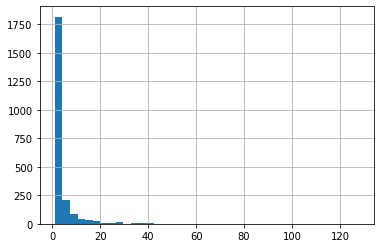

In [993]:
df_combined['Counts'].hist(bins=40)

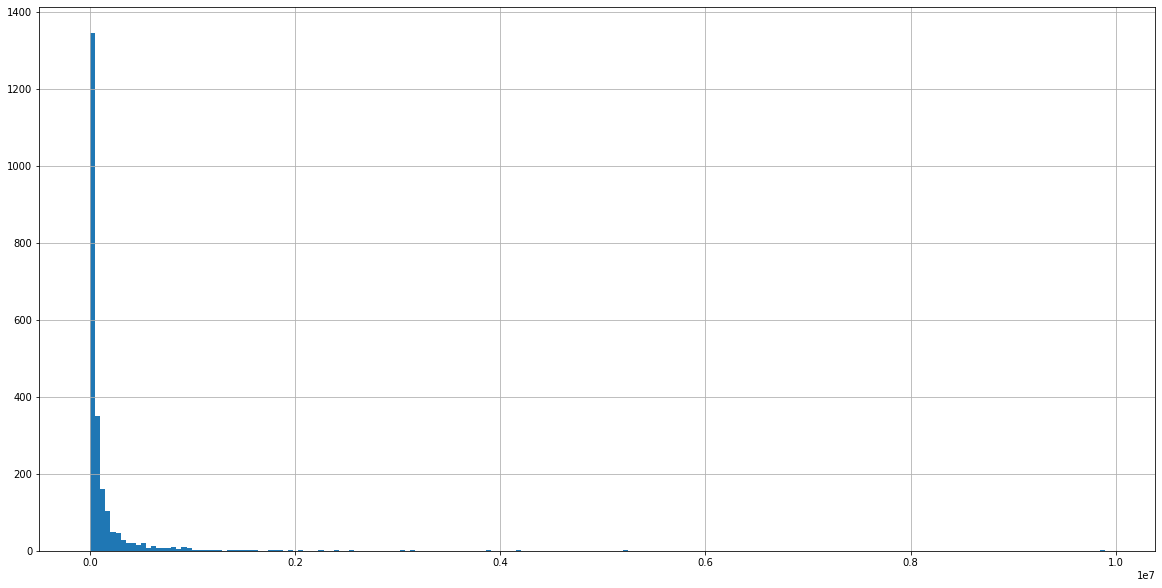

In [994]:
df_combined['population'].hist(bins=200,figsize=(20,10))

In [995]:
i=1
while i>=0:
    print('\nQuantile:',i,'\nCounts',df_combined['Counts'].quantile(i))
    i-=0.01
#df_combined['Counts'].quantile(0.5)     #.hist(bins=50,figsize=(20,10))


Quantile: 1 
Counts 128.0

Quantile: 0.99 
Counts 29.0

Quantile: 0.98 
Counts 21.0

Quantile: 0.97 
Counts 18.0

Quantile: 0.96 
Counts 15.0

Quantile: 0.95 
Counts 13.0

Quantile: 0.94 
Counts 11.0

Quantile: 0.9299999999999999 
Counts 10.0

Quantile: 0.9199999999999999 
Counts 9.0

Quantile: 0.9099999999999999 
Counts 8.0

Quantile: 0.8999999999999999 
Counts 8.0

Quantile: 0.8899999999999999 
Counts 7.0

Quantile: 0.8799999999999999 
Counts 7.0

Quantile: 0.8699999999999999 
Counts 6.0

Quantile: 0.8599999999999999 
Counts 6.0

Quantile: 0.8499999999999999 
Counts 6.0

Quantile: 0.8399999999999999 
Counts 5.0

Quantile: 0.8299999999999998 
Counts 5.0

Quantile: 0.8199999999999998 
Counts 5.0

Quantile: 0.8099999999999998 
Counts 5.0

Quantile: 0.7999999999999998 
Counts 4.0

Quantile: 0.7899999999999998 
Counts 4.0

Quantile: 0.7799999999999998 
Counts 4.0

Quantile: 0.7699999999999998 
Counts 4.0

Quantile: 0.7599999999999998 
Counts 4.0

Quantile: 0.7499999999999998 
Counts 4.0


Approximately 33% of the counties have 3 or more farmer's market. Let's take a quick look at what that represents population wise.

In [996]:
df_combined[df_combined['Counts']>=3].head()

,county,State,per capita income,median household income,median family income,population,number of households,County_State,Counts,website_count,...,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN,counts_per_capita
0,New York,New York,62498.0,69659.0,84627.0,1605272.0,736192.0,"New York, New York",63,47,...,4.0,0.0,44.0,1.0,5.0,2.0,0.0,1.0,3.0,0.039246
1,Arlington,Virginia,62018.0,103208.0,139244.0,214861.0,94454.0,"Arlington, Virginia",12,11,...,4.0,0.0,10.0,0.0,8.0,1.0,2.0,0.0,0.0,0.055850
2,Marin,California,56791.0,90839.0,117357.0,254643.0,102912.0,"Marin, California",15,10,...,8.0,6.0,9.0,8.0,7.0,6.0,4.0,5.0,2.0,0.058906
5,Fairfax,Virginia,50532.0,110292.0,128596.0,1101071.0,389908.0,"Fairfax, Virginia",25,24,...,10.0,1.0,24.0,1.0,18.0,3.0,5.0,0.0,1.0,0.022705
6,Hunterdon,New Jersey,50349.0,106143.0,125828.0,127047.0,46816.0,"Hunterdon, New Jersey",5,3,...,3.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,1.0,0.039356


In [997]:
df_combined[df_combined['Counts']>=3]['population'].sum()

241276894.0

Total population of counties that have 3 or more farmer's market is 241,276,894 and such counties make up for 33% of the total number of counties in the list. In the next section we'll use data from only those counties that have 3 or more farmer's market. Additionally a second filter on population is to be added and counties with population larger than 200,000 are to be excluded. The reason for this counties with a very large population tend to be diverse socioeconomically data by county does not give us the granularity necessary for analysis.

In [998]:
df_combined=df_combined[(df_combined['Counts']>=3) & (df_combined['population']<=200000)].sort_values(by='counts_per_capita',ascending=False)

In [999]:
df_combined.corr()

,per capita income,median household income,median family income,population,number of households,Counts,website_count,OrganicYN,BakedgoodsYN,CheeseYN,...,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN,counts_per_capita
per capita income,1.000000,0.884790,0.904831,0.217706,0.227036,0.187306,0.271896,0.228538,0.222523,0.232520,...,0.264225,0.099299,0.176707,0.057990,0.197155,0.258521,0.228208,0.186635,0.175089,-0.052593
median household income,0.884790,1.000000,0.960401,0.296057,0.271784,0.165033,0.239687,0.151499,0.164760,0.147666,...,0.208155,0.035726,0.131335,-0.021051,0.122734,0.179330,0.195057,0.116541,0.102535,-0.189934
median family income,0.904831,0.960401,1.000000,0.312613,0.298726,0.190533,0.284187,0.198349,0.207693,0.184526,...,0.257232,0.063415,0.166499,0.032189,0.158472,0.226397,0.234950,0.151408,0.144997,-0.172014
population,0.217706,0.296057,0.312613,1.000000,0.993378,0.333134,0.372597,0.256335,0.253927,0.302197,...,0.284913,0.146181,0.259909,0.116795,0.213126,0.202764,0.277761,0.123359,0.083700,-0.599824
number of households,0.227036,0.271784,0.298726,0.993378,1.000000,0.342912,0.383071,0.273143,0.270840,0.321908,...,0.292708,0.162067,0.271359,0.127383,0.226804,0.216055,0.285364,0.130846,0.098871,-0.593838
Counts,0.187306,0.165033,0.190533,0.333134,0.342912,1.000000,0.711942,0.651286,0.716929,0.627795,...,0.568213,0.325546,0.668268,0.230809,0.452284,0.542310,0.316565,0.344174,0.411486,0.028135
website_count,0.271896,0.239687,0.284187,0.372597,0.383071,0.711942,1.000000,0.689639,0.721601,0.685973,...,0.599587,0.383267,0.711939,0.286920,0.505896,0.558740,0.364879,0.361055,0.446201,-0.113446
OrganicYN,0.228538,0.151499,0.198349,0.256335,0.273143,0.651286,0.689639,1.000000,0.723274,0.719991,...,0.619063,0.454498,0.669992,0.350944,0.553764,0.610202,0.371248,0.384622,0.540863,-0.044915
BakedgoodsYN,0.222523,0.164760,0.207693,0.253927,0.270840,0.716929,0.721601,0.723274,1.000000,0.760183,...,0.639439,0.437494,0.857904,0.302988,0.535943,0.587855,0.445604,0.358043,0.544069,-0.005187
CheeseYN,0.232520,0.147666,0.184526,0.302197,0.321908,0.627795,0.685973,0.719991,0.760183,1.000000,...,0.650010,0.435652,0.694461,0.330414,0.584715,0.627481,0.472533,0.415803,0.558255,-0.070921


In [1000]:
df_combined.columns.values

array(['county', 'State', 'per capita income', 'median household income',
       'median family income', 'population', 'number of households',
       'County_State', 'Counts', 'website_count', 'OrganicYN',
       'BakedgoodsYN', 'CheeseYN', 'CraftsYN', 'FlowersYN', 'EggsYN',
       'SeafoodYN', 'HerbsYN', 'VegetablesYN', 'HoneyYN', 'JamsYN',
       'MapleYN', 'MeatYN', 'NurseryYN', 'NutsYN', 'PlantsYN',
       'PoultryYN', 'PreparedYN', 'SoapYN', 'TreesYN', 'WineYN',
       'CoffeeYN', 'BeansYN', 'FruitsYN', 'GrainsYN', 'JuicesYN',
       'MushroomsYN', 'PetFoodYN', 'TofuYN', 'WildHarvestedYN',
       'counts_per_capita'], dtype=object)

In [1001]:
df_features=df_combined[['Counts', 'website_count', 'OrganicYN','BakedgoodsYN', 'CheeseYN', 'CraftsYN', 'FlowersYN', 'EggsYN','SeafoodYN', 'HerbsYN', 'VegetablesYN', 'HoneyYN', 'JamsYN','MapleYN', 'MeatYN', 'NurseryYN', 'NutsYN', 'PlantsYN','PoultryYN', 'PreparedYN', 'SoapYN', 'TreesYN', 'WineYN','CoffeeYN', 'BeansYN', 'FruitsYN', 'GrainsYN', 'JuicesYN','MushroomsYN', 'PetFoodYN', 'TofuYN', 'WildHarvestedYN','counts_per_capita','per capita income', 'median household income','median family income']].copy(deep=True)  #'population', 'number of households', 

In [1002]:
df_features.head()

,Counts,website_count,OrganicYN,BakedgoodsYN,CheeseYN,CraftsYN,FlowersYN,EggsYN,SeafoodYN,HerbsYN,...,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN,counts_per_capita,per capita income,median household income,median family income
1441,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.947269,21843.0,33647.0,44605.0
1022,3,0,0.0,3.0,1.0,3.0,2.0,2.0,1.0,3.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.692681,23965.0,39541.0,60954.0
1236,3,0,1.0,3.0,0.0,0.0,0.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.566465,22879.0,40143.0,48816.0
386,3,0,0.0,3.0,0.0,2.0,2.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.536385,28331.0,45343.0,61367.0
958,5,4,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.523013,24286.0,46429.0,55582.0


In [1003]:
X=df_features[['Counts', 'website_count', 'OrganicYN','BakedgoodsYN', 'CheeseYN', 'CraftsYN', 'FlowersYN', 'EggsYN','SeafoodYN', 'HerbsYN', 'VegetablesYN', 'HoneyYN', 'JamsYN','MapleYN', 'MeatYN', 'NurseryYN', 'NutsYN', 'PlantsYN','PoultryYN', 'PreparedYN', 'SoapYN', 'TreesYN', 'WineYN','CoffeeYN', 'BeansYN', 'FruitsYN', 'GrainsYN', 'JuicesYN','MushroomsYN', 'PetFoodYN', 'TofuYN', 'WildHarvestedYN','counts_per_capita']].copy(deep=True)  #'population', 'number of households', 

In [1004]:
scaler=StandardScaler()

In [1005]:
X=scaler.fit_transform(X)

/home/user-1131/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/user-1131/venv/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [1006]:
pca = PCA(n_components=4)

In [1007]:
features_principal_components=pca.fit_transform(X)

In [1008]:
principal_components=pd.DataFrame(data=features_principal_components,columns = ['principal component 1', 'principal component 2', 'principal component 3','principal_component 4'])

In [1009]:
principal_components.head()

,principal component 1,principal component 2,principal component 3,principal_component 4
0,-5.442264,-0.241596,-3.718649,6.479910
1,-0.927908,0.106498,-1.651028,5.744056
2,-3.042977,-1.024404,-1.957441,3.499461
3,-3.403211,-1.164628,-1.808315,3.486533
4,-4.113832,-0.493598,-1.907464,3.078195


In [1010]:
pca.explained_variance_ratio_

array([0.5693485 , 0.06364392, 0.03803276, 0.03205771])

In [1011]:
y=df_features[['per capita income']]

In [1012]:
from sklearn.model_selection import train_test_split
pca_train, pca_test, y_train, y_test = train_test_split(principal_components, y, test_size=0.2, random_state=0)

In [1013]:
from sklearn.linear_model import LinearRegression
regressor=LinearRegression()

In [1014]:
regressor.fit(pca_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [1015]:
y_pred=regressor.predict(pca_test)

In [1016]:
regressor.coef_

array([[ 285.70461479,  417.28156266, -208.59794962, -641.36725706]])

In [1017]:
y_test

,per capita income
1942,18897.0
1586,21102.0
2069,17876.0
1721,20340.0
538,26955.0
736,25625.0
368,28600.0
1527,21388.0
1381,22160.0
1392,22081.0


In [1018]:
y_pred

array([[25025.90735908],
       [24504.3365272 ],
       [24846.51480159],
       [25157.0703107 ],
       [29594.06377517],
       [24045.59420036],
       [25201.86118008],
       [25234.48919646],
       [24349.031378  ],
       [25345.22614501],
       [25829.75898948],
       [25241.46192057],
       [25808.84927643],
       [24823.05390848],
       [24653.31496153],
       [24812.493633  ],
       [23868.55365572],
       [26087.71177825],
       [26880.64907112],
       [24242.326109  ],
       [23351.61402333],
       [26061.65534353],
       [35309.26568143],
       [25320.39517145],
       [25319.34546258],
       [26942.67389192],
       [23848.24386641],
       [24564.30205582],
       [25086.08751699],
       [24498.03753186],
       [25572.84409551],
       [22823.49429394],
       [24590.82044088],
       [28240.52787331],
       [25086.48056116],
       [25902.52281477],
       [24722.61506   ],
       [25003.31687006],
       [24410.6645968 ],
       [24516.66527362],


In [1019]:
per_capita_income_predicted=pd.DataFrame(y_pred)
per_capita_income_predicted.head()

,0
0,25025.907359
1,24504.336527
2,24846.514802
3,25157.070311
4,29594.063775


In [1020]:
df=y_test.copy(deep=True)
df.head()

,per capita income
1942,18897.0
1586,21102.0
2069,17876.0
1721,20340.0
538,26955.0


In [1021]:
df['per capita income - predicted']=y_pred
df.head(100)

,per capita income,per capita income - predicted
1942,18897.0,25025.907359
1586,21102.0,24504.336527
2069,17876.0,24846.514802
1721,20340.0,25157.070311
538,26955.0,29594.063775
736,25625.0,24045.594200
368,28600.0,25201.861180
1527,21388.0,25234.489196
1381,22160.0,24349.031378
1392,22081.0,25345.226145


In [1022]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(df['per capita income'].values, df['per capita income - predicted'].values))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared:',metrics.r2_score(y_test,y_pred))

Mean Absolute Error: 3757.6096505928267
Mean Squared Error: 22192057.82196267
Root Mean Squared Error: 4710.844703655882
R-squared: 0.12823241864592305


It's evident that the problem is not quite amenable to linear regression.

In the next section we'll attempt clustering the counties to see how clusters relate to per capita income.

In [1023]:
km=KMeans(n_clusters=3, init='k-means++', n_init=100, max_iter=1000,tol=1e-05, random_state=0)

In [1024]:
y_km=km.fit_predict(principal_components)

In [1025]:
principal_components['centroid']=y_km

In [1026]:
principal_components['per capita income']=y.values

In [1027]:
principal_components.head()

,principal component 1,principal component 2,principal component 3,principal_component 4,centroid,per capita income
0,-5.442264,-0.241596,-3.718649,6.479910,1,21843.0
1,-0.927908,0.106498,-1.651028,5.744056,1,23965.0
2,-3.042977,-1.024404,-1.957441,3.499461,1,22879.0
3,-3.403211,-1.164628,-1.808315,3.486533,1,28331.0
4,-4.113832,-0.493598,-1.907464,3.078195,1,24286.0


In [1028]:
principal_components.groupby(['centroid']).median()

,principal component 1,principal component 2,principal component 3,principal_component 4,per capita income
centroid,,,,,
0,10.831185,0.032162,-1.112967,-0.366293,29377.0
1,-2.212028,0.109838,-0.184438,-0.183461,23844.5
2,1.487646,-0.414889,0.222149,-0.204846,25369.0


In [1029]:
principal_components.groupby(['centroid']).std()

,principal component 1,principal component 2,principal component 3,principal_component 4,per capita income
centroid,,,,,
0,5.902408,2.809995,2.866041,1.694991,4237.238003
1,1.520382,0.876956,0.757526,0.989008,4610.118483
2,2.012135,1.846007,1.156657,0.971957,5133.274720


In [1030]:
principal_components.corr()

,principal component 1,principal component 2,principal component 3,principal_component 4,centroid,per capita income
principal component 1,1.000000e+00,-7.377143e-18,-4.215191e-17,2.633549e-16,0.043935,0.254198
principal component 2,-7.377143e-18,1.000000e+00,1.223702e-17,5.860665e-17,-0.112360,0.102630
principal component 3,-4.215191e-17,1.223702e-17,1.000000e+00,-6.468961e-17,0.174637,-0.063040
principal_component 4,2.633549e-16,5.860665e-17,-6.468961e-17,1.000000e+00,-0.068998,-0.123627
centroid,4.393504e-02,-1.123598e-01,1.746372e-01,-6.899759e-02,1.000000,0.068012
per capita income,2.541983e-01,1.026298e-01,-6.303957e-02,-1.236267e-01,0.068012,1.000000


Let's plot a boxplot to visualize income range for each distribution.

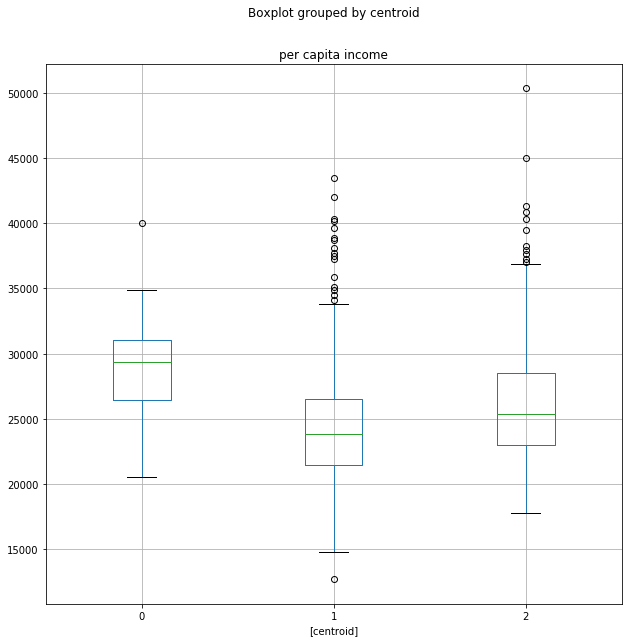

In [1031]:
income_by_cluster=principal_components.boxplot(column=['per capita income'],by=['centroid'],figsize=(10,10))

Let's perform one-way ANOVA to verify if differences are statistically significant.

In [1032]:
import scipy.stats as stats

stats.f_oneway(principal_components['per capita income'][principal_components['centroid'] == 0],
               principal_components['per capita income'][principal_components['centroid'] == 1],
               principal_components['per capita income'][principal_components['centroid'] == 2])
               #principal_components['per capita income'][principal_components['centroid'] == 3])
               #principal_components['per capita income'][principal_components['centroid'] == 4])

F_onewayResult(statistic=18.288123989840237, pvalue=2.0238541174285843e-08)

In [1033]:
import researchpy as rp

rp.summary_cont(principal_components['per capita income'].groupby(principal_components['centroid']))

,N,Mean,SD,SE,95% Conf.,Interval
centroid,,,,,,
0,28,28931.2500,4237.2380,800.7627,27288.2206,30574.2794
1,328,24453.6433,4610.1185,254.5512,23952.8787,24954.4079
2,207,26376.4831,5133.2747,356.7873,25673.0604,27079.9058


Tukey Honestly Significant Difference test to pair-wise verify statistical significance.

In [1034]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(principal_components['per capita income'],principal_components['centroid'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-4477.6067,0.001,-6695.0698,-2260.1436,True
0,2,-2554.7669,0.0227,-4822.6313,-286.9025,True
1,2,1922.8398,0.001,923.0651,2922.6145,True


In [1035]:
principal_components.head()

,principal component 1,principal component 2,principal component 3,principal_component 4,centroid,per capita income
0,-5.442264,-0.241596,-3.718649,6.479910,1,21843.0
1,-0.927908,0.106498,-1.651028,5.744056,1,23965.0
2,-3.042977,-1.024404,-1.957441,3.499461,1,22879.0
3,-3.403211,-1.164628,-1.808315,3.486533,1,28331.0
4,-4.113832,-0.493598,-1.907464,3.078195,1,24286.0


In [1036]:
df_combined['PreparedYN']

1441    0.0
1022    3.0
1236    1.0
386     1.0
958     0.0
156     2.0
810     0.0
1003    2.0
1621    1.0
1581    0.0
743     1.0
437     0.0
33      3.0
1532    0.0
1268    0.0
255     0.0
1896    1.0
618     1.0
1715    3.0
829     0.0
769     0.0
297     1.0
711     0.0
1913    0.0
762     1.0
860     3.0
910     0.0
915     0.0
216     4.0
418     1.0
       ... 
941     3.0
798     3.0
1083    2.0
1320    3.0
982     2.0
1035    2.0
567     2.0
807     1.0
2077    3.0
609     0.0
74      3.0
56      3.0
445     1.0
257     1.0
1604    1.0
1044    0.0
1293    2.0
450     2.0
626     3.0
944     1.0
1304    0.0
813     1.0
367     3.0
128     1.0
337     1.0
1321    2.0
234     2.0
945     2.0
282     2.0
355     1.0
Name: PreparedYN, Length: 563, dtype: float64

In [1037]:
principal_components['Population']=df_combined['population'].values

In [1038]:
principal_components['PreparedYN per Farmers Market']=(df_combined['PreparedYN']/df_combined['Counts']).values

In [1039]:
principal_components['CoffeeYN per Farmers Market']=(df_combined['CoffeeYN']/df_combined['Counts']).values

In [1040]:
principal_components['OrganicYN per Farmers Market']=(df_combined['OrganicYN']/df_combined['Counts']).values

In [1041]:
principal_components['SeafoodYN per Farmers Market']=(df_combined['SeafoodYN']/df_combined['Counts']).values

In [1042]:
principal_components['Nurseries per Farmers Market']=(df_combined['NurseryYN']/df_combined['Counts']).values

In [1043]:
principal_components['Counts']=df_combined['Counts'].values

In [1044]:
principal_components['Counts per Capita']=df_combined['counts_per_capita'].values

In [1045]:
principal_components.head()

,principal component 1,principal component 2,principal component 3,principal_component 4,centroid,per capita income,Population,PreparedYN per Farmers Market,CoffeeYN per Farmers Market,OrganicYN per Farmers Market,SeafoodYN per Farmers Market,Nurseries per Farmers Market,Counts,Counts per Capita
0,-5.442264,-0.241596,-3.718649,6.479910,1,21843.0,3167.0,0.000000,0.000000,0.000000,0.000000,0.0,3,0.947269
1,-0.927908,0.106498,-1.651028,5.744056,1,23965.0,4331.0,1.000000,0.666667,0.000000,0.333333,0.0,3,0.692681
2,-3.042977,-1.024404,-1.957441,3.499461,1,22879.0,5296.0,0.333333,0.000000,0.333333,0.000000,0.0,3,0.566465
3,-3.403211,-1.164628,-1.808315,3.486533,1,28331.0,5593.0,0.333333,0.000000,0.000000,0.000000,0.0,3,0.536385
4,-4.113832,-0.493598,-1.907464,3.078195,1,24286.0,9560.0,0.000000,0.000000,0.000000,0.000000,0.0,5,0.523013


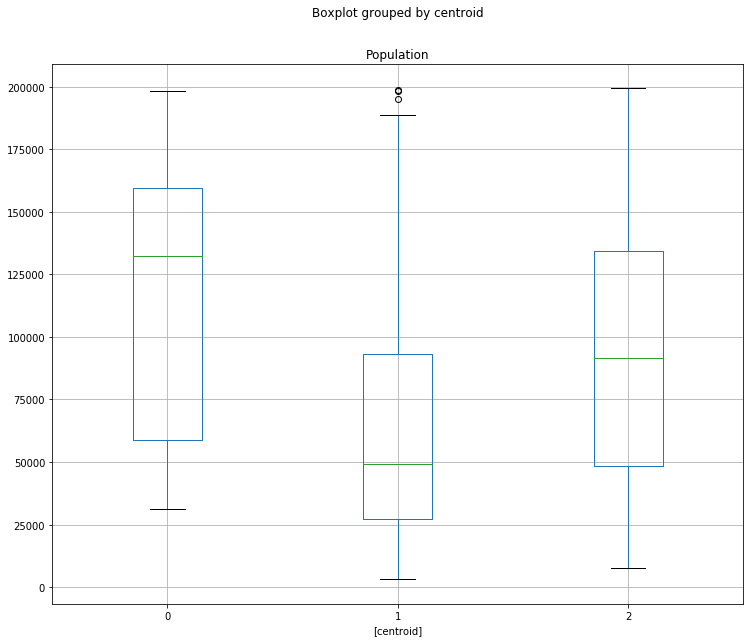

In [1046]:
County_Population=principal_components.boxplot(column=['Population'],by=['centroid'],figsize=(12,10))

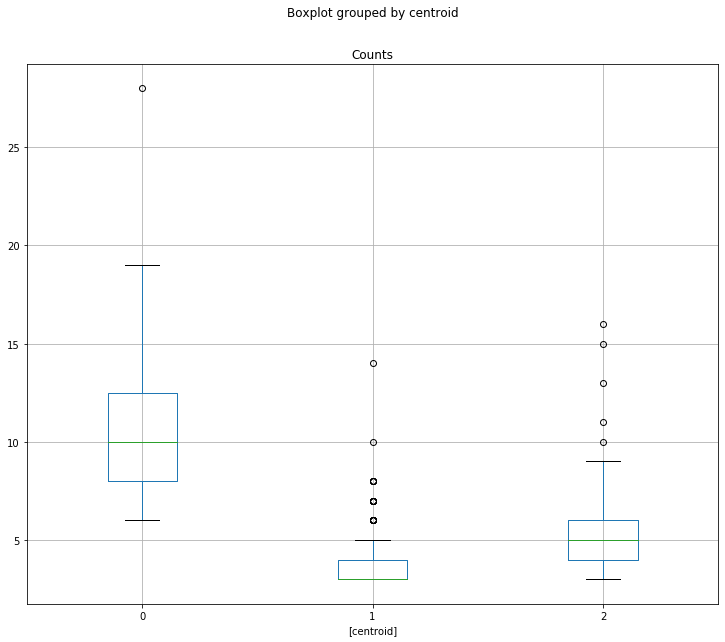

In [1047]:
Number_of_Farmers_Market=principal_components.boxplot(column=['Counts'],by=['centroid'],figsize=(12,10))

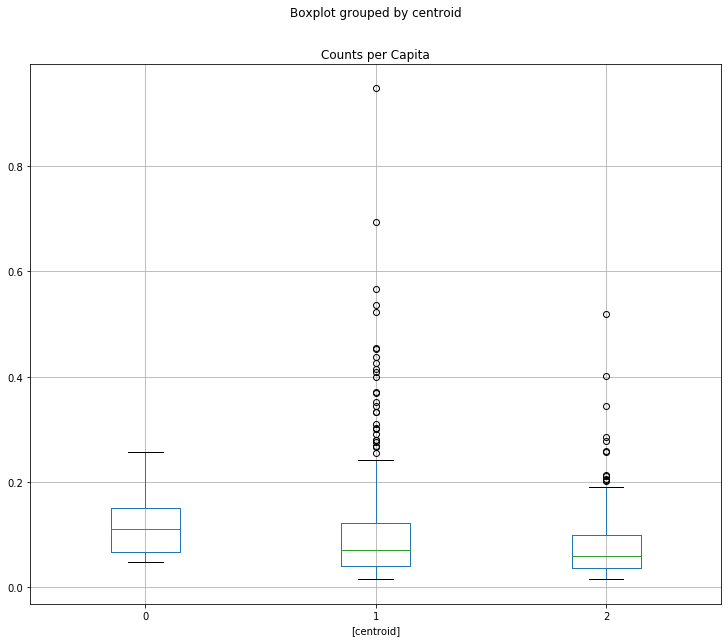

In [1048]:
Number_of_Farmers_Market=principal_components.boxplot(column=['Counts per Capita'],by=['centroid'],figsize=(12,10))

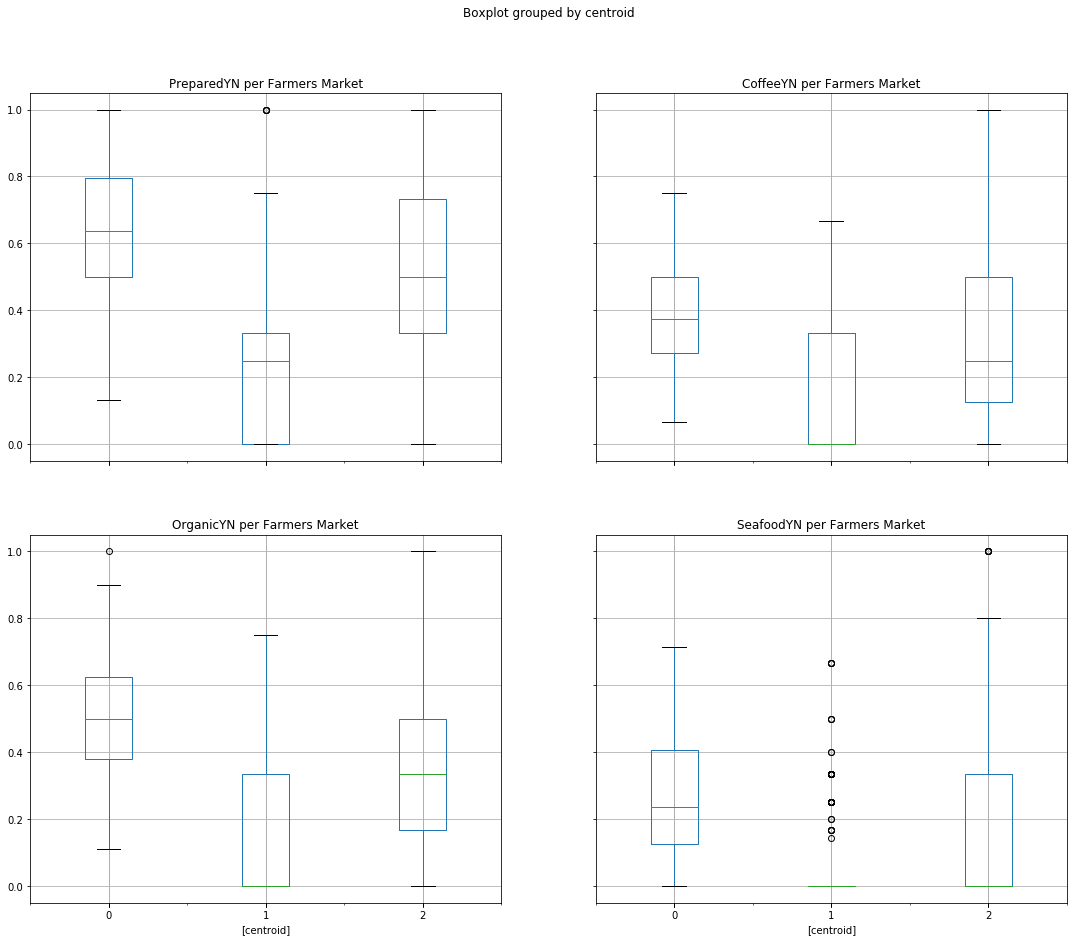

In [1049]:
Farmers_Market_Availability=principal_components.boxplot(column=['PreparedYN per Farmers Market','CoffeeYN per Farmers Market','OrganicYN per Farmers Market','SeafoodYN per Farmers Market'],by=['centroid'],figsize=(18,15))

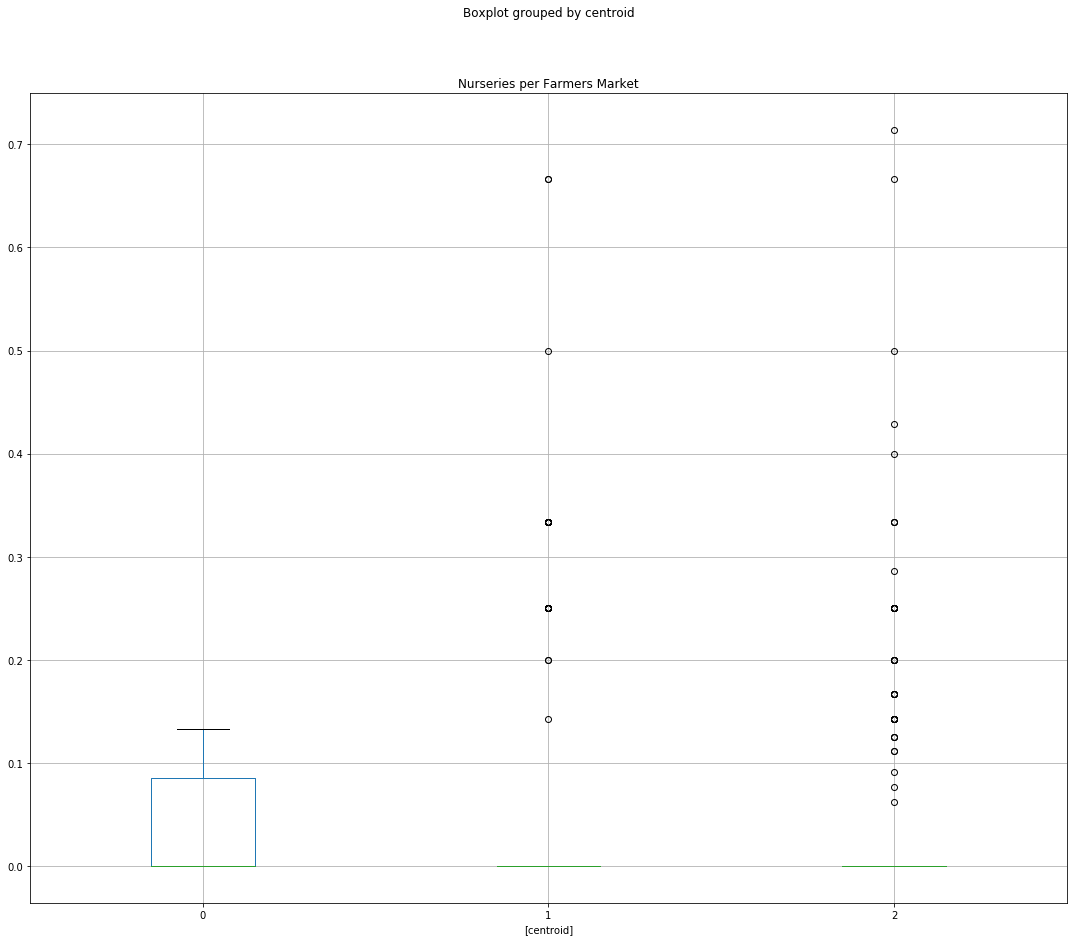

In [1050]:
On_site_Nurseries=principal_components.boxplot(column=['Nurseries per Farmers Market'],by=['centroid'],figsize=(18,15))

In [1051]:
#principal_components.groupby(['centroid'])['PreparedYN'].std()